# Notebook 3: Select Normalization Method

## Overview

This notebook helps you **evaluate and select the best normalization method** for your FTIR spectral data. Normalization is the final preprocessing step that makes spectra directly comparable by scaling intensities appropriately.

### What You'll Learn

1. How to apply denoising and baseline correction together
2. How to handle atmospheric interference (CO₂, H₂O)
3. How to evaluate 17+ normalization methods
4. How to select the best method using classification performance

### Why Normalize?

Normalization addresses:
- **Path length variations**: Different sample thicknesses
- **Concentration differences**: Varying amounts of material
- **Instrument variations**: Detector sensitivity changes
- **Scatter effects**: Light scattering from particles

### Available Normalization Methods

Xpectrass provides 7+ normalization methods:
- **SNV (Standard Normal Variate)**: Removes scatter effects
- **Vector (L2)**: Unit length scaling
- **Min-Max**: Scales to 0-1 range
- **Area**: Normalizes total spectral area
- **Peak**: Scales to maximum peak
- **PQN (Probabilistic Quotient)**: Robust to dilution
- **Entropy-weighted**: Information theory-based

### Evaluation Strategy

Unlike denoising and baseline correction, normalization is evaluated using **classification performance**:
- **Cross-validation accuracy**: How well can we classify after normalization?
- **Between-group separation**: Are different polymer types more distinguishable?
- **Within-group consistency**: Are same-type polymers more similar?

The method that produces the best classification performance is typically the best choice.

### Expected Output

- Preprocessed data with denoising, baseline correction, and atmospheric correction
- Classification accuracy for each normalization method
- Excel file with ranked normalization methods
- Recommendation for final preprocessing pipeline

---

## Step 1: Load Data and Define Parameters

In [1]:
# Import required modules
import polars as pl
from xpectrass import FTIRdataprocessing
from xpectrass import load_villegas_camacho_2024_c4

# Load the dataset
dataset = load_villegas_camacho_2024_c4()
print('Dataset shape:', dataset.shape)

# Define the label column
LABEL_COLUMN = "type"

# Flat windows for baseline evaluation (from Notebook 2)
FLAT_WINDOWS = [(1880, 1900), (2400, 2700)]

# Selected methods from previous notebooks
DENOISING_METHOD = 'wavelet'  # From Notebook 1
BASELINE_CORRECTION_METHOD = 'aspls'  # From Notebook 2

# Define atmospheric regions to handle
# EXCLUDE_REGIONS: Completely remove these spectral regions
EXCLUDE_REGIONS = [
    (0, 680),       # Low wavenumber noise region + CO₂ bending (670 cm⁻¹)
    (3500, 5000)    # High wavenumber noise region + O–H stretch
]

# INTERPOLATE_REGIONS: Replace these regions with interpolated values
# This is useful for atmospheric interference regions (CO₂, H₂O)
INTERPOLATE_REGIONS = [
    (1250, 2700)    # H₂O bend region + CO₂ stretch region
]

# Interpolation method: "zero", "linear", or "spline"
# "zero" sets the region to baseline (recommended for atmospheric correction)
INTERPOLATE_METHOD = "zero"

print(f"\nPreprocessing parameters:")
print(f"  Denoising method: {DENOISING_METHOD}")
print(f"  Baseline method: {BASELINE_CORRECTION_METHOD}")
print(f"  Exclude regions: {EXCLUDE_REGIONS}")
print(f"  Interpolate regions: {INTERPOLATE_REGIONS}")
print(f"  Interpolation method: {INTERPOLATE_METHOD}")
print("\nFirst few rows of data:")
print(dataset.head(5))

Dataset shape: (3000, 3741)

Preprocessing parameters:
  Denoising method: wavelet
  Baseline method: aspls
  Exclude regions: [(0, 680), (3500, 5000)]
  Interpolate regions: [(1250, 2700)]
  Interpolation method: zero

First few rows of data:
                   study sample_id  type environmental resolution  399.1927  \
0  Villegas-Camacho 2024     HDPE1  HDPE             N          H   94.7263   
1  Villegas-Camacho 2024    HDPE10  HDPE             N          H   92.5425   
2  Villegas-Camacho 2024   HDPE100  HDPE             N          H   81.2087   
3  Villegas-Camacho 2024   HDPE101  HDPE             N          H   89.2102   
4  Villegas-Camacho 2024   HDPE102  HDPE             N          H   85.7056   

   400.1569  401.1211  402.0854  403.0496  ...  3991.9265  3992.8906  \
0   94.9387   94.7092   94.2910   93.9484  ...   114.0090   113.9980   
1   93.1795   93.3965   93.3499   93.2530  ...   109.5880   109.5800   
2   83.2487   85.0425   86.4187   87.3435  ...   106.9950   107.0

### Understanding Atmospheric Correction

**Why handle atmospheric interference?**
- CO₂ and H₂O in the air between sample and detector create absorption peaks
- These peaks are not from your sample and should be removed
- Common atmospheric regions: 670 cm⁻¹ (CO₂), 1400-1900 cm⁻¹ (H₂O), 2350 cm⁻¹ (CO₂), 3500+ cm⁻¹ (H₂O)

**Two approaches:**
1. **EXCLUDE**: Completely remove regions (edges, noise)
2. **INTERPOLATE**: Replace with baseline (atmospheric peaks)

**Interpolation methods:**
- `"zero"`: Set to zero/baseline (recommended for atmospheric regions)
- `"linear"`: Linear interpolation between boundaries
- `"spline"`: Smooth spline interpolation

---

## Step 2: Apply Full Preprocessing Pipeline

Applying preprocessing pipeline:
  1. Convert to absorbance
  2. Denoise spectra
  3. Correct baseline
  4. Handle atmospheric interference

This may take a few minutes for large datasets...

Auto-detected: Transmittance → Converting to Absorbance
########## Plotting Converted Spectra! ##########
Auto-detected: Absorbance


100%|██████████| 3000/3000 [00:03<00:00, 986.91it/s] 


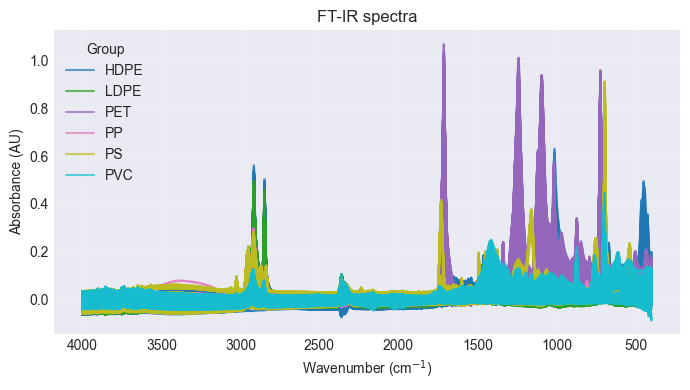

Denoising (wavelet): 100%|██████████| 3000/3000 [00:00<00:00, 11553.40it/s]
WARNING - Denoising produced 5071997 negative absorbance values (45.3% of valid points, min=-0.0852). This is physically invalid and may indicate: (1) aggressive smoothing parameters, (2) baseline drift in input data, or (3) input data already near zero. Recommendations: Apply baseline correction before denoising, or adjust denoising parameters (e.g., reduce window_length for savgol).


########## Plotting Denoised Spectra! ##########
Auto-detected: Absorbance


100%|██████████| 3000/3000 [00:03<00:00, 947.54it/s]


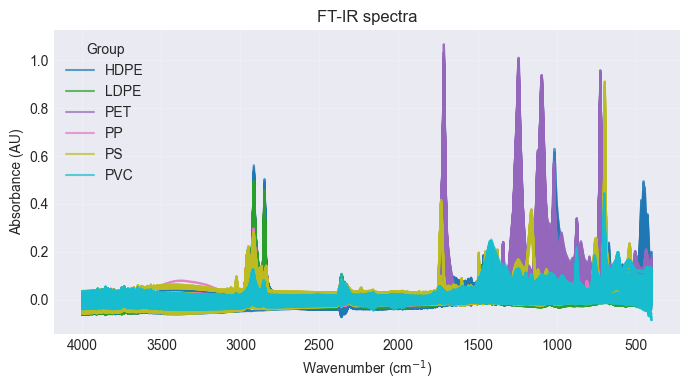

Baseline correction (aspls): 100%|██████████| 3000/3000 [01:34<00:00, 31.85it/s]
WARNING - Baseline correction produced 3334901 negative absorbance values (29.8% of valid points, min=-0.0115). This is physically invalid. The baseline may be over-estimated. Recommendations: (1) Set clip_negative=True to clip values to 0, (2) Try different baseline method (e.g., 'asls', 'arpls'), or (3) Adjust method parameters (e.g., increase lam, decrease p).


########## Plotting Baseline Corrected Spectra! ##########
Auto-detected: Absorbance


100%|██████████| 3000/3000 [00:03<00:00, 928.31it/s]


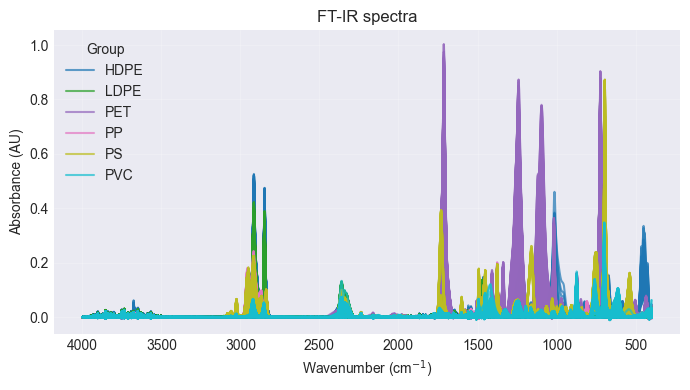

Processing Regions: 100%|██████████| 3000/3000 [00:00<00:00, 9277.99it/s]


########## Plotting Atmospheric Interference Corrected Spectra! ##########
Auto-detected: Absorbance


100%|██████████| 3000/3000 [00:02<00:00, 1068.14it/s]


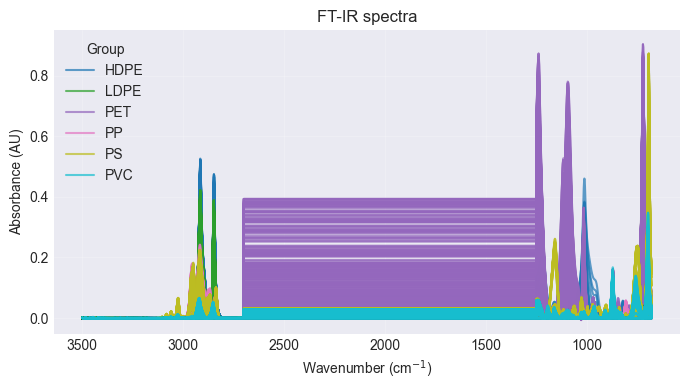


✓ Preprocessing complete!
Corrected data shape: (3000, 2929)
Original features: 3740
After region exclusion: 2928

✓ Preprocessed data saved to: denoised_baseline_atmospheric_corrected_data.xlsx


In [2]:
# Initialize the preprocessing pipeline with all parameters
fdp = FTIRdataprocessing(
    df=dataset,
    label_column=LABEL_COLUMN,
    exclude_regions=EXCLUDE_REGIONS,
    interpolate_regions=INTERPOLATE_REGIONS,
    flat_windows=FLAT_WINDOWS
)

print("Applying preprocessing pipeline:")
print("  1. Convert to absorbance")
print("  2. Denoise spectra")
print("  3. Correct baseline")
print("  4. Handle atmospheric interference")
print("\nThis may take a few minutes for large datasets...\n")

# Apply full preprocessing: conversion + denoising + baseline + atmospheric correction
# This is a helper method that combines multiple steps
df_corrected = fdp._get_atmosphere_corrected_data(
    denoising_method=DENOISING_METHOD,
    baseline_correction_method=BASELINE_CORRECTION_METHOD,
    interpolate_method=INTERPOLATE_METHOD,
    plot=True,  # Show before/after comparison
)

print(f"\n✓ Preprocessing complete!")
print(f"Corrected data shape: {df_corrected.shape}")
print(f"Original features: {dataset.shape[1] - 1}")
print(f"After region exclusion: {df_corrected.shape[1] - 1}")

# Save the preprocessed (but not normalized) data
output_file = 'denoised_baseline_atmospheric_corrected_data.xlsx'
df_corrected.to_excel(output_file, index=False)
print(f"\n✓ Preprocessed data saved to: {output_file}")

### What Just Happened?

The pipeline applied multiple preprocessing steps in the correct order:

1. **Conversion**: Transmittance → Absorbance
2. **Denoising**: Applied your selected method (wavelet, savgol, etc.)
3. **Baseline Correction**: Applied your selected method (asls, airpls, etc.)
4. **Atmospheric Correction**: 
   - Excluded low/high wavenumber noise regions
   - Interpolated over CO₂ and H₂O regions

**Important**: The data is now ready for normalization evaluation!

---

## Step 3: Evaluate Normalization Methods

Now we'll evaluate all normalization methods using **classification performance**. The method that produces the best classification accuracy is typically the best choice for your preprocessing pipeline.

In [3]:
# Import data handling libraries
import pandas as pd
import polars as pl

print("="*80)
print("Evaluating normalization methods using classification performance")
print("="*80)

# Check data format
is_polars = isinstance(df_corrected, pl.DataFrame)

# Get unique polymer types
if is_polars:
    labels = df_corrected.get_column(LABEL_COLUMN).unique().sort().to_list()
else:
    labels = df_corrected[LABEL_COLUMN].sort_values().unique().tolist()

print(f"\nFound {len(labels)} polymer types: {labels}")
print("\nThis evaluation uses cross-validation to test classification performance")
print("with each normalization method. This may take several minutes...\n")

# Store results for all polymer types
all_results = []

# Evaluate normalization methods
# Note: We evaluate on the full dataset, not per polymer type
# This is because normalization quality is measured by classification performance
for i, label in enumerate(labels, 1):
    print(f"{'='*80}")
    print(f"[{i}/{len(labels)}] Evaluating for polymer type: {label}")
    print(f"{'='*80}\n")
    
    # Filter data for current polymer type (for reporting purposes)
    if is_polars:
        df_label = df_corrected.filter(pl.col(LABEL_COLUMN) == label)
    else:
        df_label = df_corrected[df_corrected[LABEL_COLUMN] == label]
    
    print(f"Number of {label} samples: {len(df_label)}\n")
    
    # Evaluate normalization methods using classification
    # data=df_corrected: Use full dataset (not just one polymer type)
    # methods="FTIR": Test FTIR-specific normalization methods
    # n_splits=5: Use 5-fold cross-validation for robust evaluation
    result = fdp.find_normalization_method(
        data=df_corrected,  # Full dataset for classification
        methods="FTIR",
        n_splits=5,
    )
    
    # Add polymer type label to results (for tracking purposes)
    result = result.copy()
    result["type"] = label
    all_results.append(result)
    
    # Display top method
    top_method = result.iloc[0]
    print(f"\n✓ Top normalization method for {label}: {top_method['method']}")
    print(f"  Classification accuracy: {top_method.get('accuracy', 'N/A')}")

# Combine results from all iterations
print("\n" + "="*80)
print("Saving combined results...")
print("="*80)

final_df = pd.concat(all_results, ignore_index=True)

# Save results to Excel
output_file = 'normalization_methods_scores.xlsx'
final_df.to_excel(output_file, index=False)

print(f"\n✓ Results saved to: {output_file}")
print(f"Total evaluations: {len(final_df)}")

# Display summary of top methods
print("\n" + "="*80)
print("SUMMARY: Recommended normalization methods")
print("="*80)

# Group by method and calculate average performance
if 'accuracy' in final_df.columns:
    method_summary = final_df.groupby('method')['accuracy'].mean().sort_values(ascending=False)
    print("\nAverage classification accuracy by method:")
    for method, accuracy in method_summary.head(5).items():
        print(f"  {method:20s} → {accuracy:.4f}")
else:
    print("\nTop method from first evaluation:")
    print(f"  {final_df.iloc[0]['method']}")

Evaluating normalization methods using classification performance

Found 6 polymer types: ['HDPE', 'LDPE', 'PET', 'PP', 'PS', 'PVC']

This evaluation uses cross-validation to test classification performance
with each normalization method. This may take several minutes...

[1/6] Evaluating for polymer type: HDPE

Number of HDPE samples: 500



Evaluating normalization methods: 100%|██████████| 17/17 [00:41<00:00,  2.46s/it]



✓ Top normalization method for HDPE: snv_detrend
  Classification accuracy: N/A
[2/6] Evaluating for polymer type: LDPE

Number of LDPE samples: 500



Evaluating normalization methods: 100%|██████████| 17/17 [00:41<00:00,  2.42s/it]



✓ Top normalization method for LDPE: spectral_moments
  Classification accuracy: N/A
[3/6] Evaluating for polymer type: PET

Number of PET samples: 500



Evaluating normalization methods: 100%|██████████| 17/17 [00:40<00:00,  2.37s/it]



✓ Top normalization method for PET: snv_detrend
  Classification accuracy: N/A
[4/6] Evaluating for polymer type: PP

Number of PP samples: 500



Evaluating normalization methods: 100%|██████████| 17/17 [00:41<00:00,  2.44s/it]



✓ Top normalization method for PP: spectral_moments
  Classification accuracy: N/A
[5/6] Evaluating for polymer type: PS

Number of PS samples: 500



Evaluating normalization methods: 100%|██████████| 17/17 [00:40<00:00,  2.39s/it]



✓ Top normalization method for PS: snv
  Classification accuracy: N/A
[6/6] Evaluating for polymer type: PVC

Number of PVC samples: 500



Evaluating normalization methods: 100%|██████████| 17/17 [00:40<00:00,  2.38s/it]


✓ Top normalization method for PVC: snv_detrend
  Classification accuracy: N/A

Saving combined results...

✓ Results saved to: normalization_methods_scores.xlsx
Total evaluations: 102

SUMMARY: Recommended normalization methods

Top method from first evaluation:
  snv_detrend


### Understanding the Results

The evaluation process:

1. **Tests each normalization method** on the preprocessed data
2. **Runs classification** using a simple classifier (e.g., Random Forest)
3. **Uses cross-validation** (5 folds) for robust accuracy estimation
4. **Ranks methods** by classification performance

### How to Interpret the Metrics

Unlike denoising and baseline correction, normalization is evaluated by:

- **Classification Accuracy**: 
  - Higher is better
  - Measures how well polymer types can be distinguished after normalization
  - The method with highest accuracy typically produces the best separation

- **Between-group vs Within-group variance**:
  - Good normalization maximizes differences between polymer types
  - While minimizing variance within each polymer type

### Common Top Methods

- **SNV (Standard Normal Variate)**: 
  - Often performs best for FTIR data
  - Removes scatter effects effectively
  - Recommended for plastic classification

- **Vector (L2 normalization)**:
  - Scales to unit length
  - Good when intensity varies but spectral shapes are important

- **Min-Max**:
  - Scales to 0-1 range
  - Good for visualization and some ML algorithms

- **Area normalization**:
  - Normalizes total absorbance
  - Good for concentration-independent comparison

### Evaluation Note

The loop iterates through polymer types for reporting purposes, but evaluates on the **full dataset** each time. This is because normalization quality is best measured by how well it improves classification of all polymer types together.

---

## Next Steps

1. **Review the Excel file** `normalization_methods_scores.xlsx`
2. **Choose the method with highest classification accuracy**
3. **Apply it in your final preprocessing pipeline**:
   ```python
   fdp.normalize(method="snv")  # Replace "snv" with your chosen method
   ```

### Complete Preprocessing Pipeline

Once you've selected your normalization method, your complete pipeline is:

```python
from xpectrass import FTIRdataprocessing

fdp = FTIRdataprocessing(df, label_column="type")

# Step 1: Convert
fdp.convert(mode="to_absorbance")

# Step 2: Denoise
fdp.denoise_spect(method="wavelet")  # Your selected method

# Step 3: Baseline correction
fdp.correct_baseline(method="aspls")  # Your selected method

# Step 4: Atmospheric correction
fdp.exclude_interpolate(method="zero")

# Step 5: Normalize
fdp.normalize(method="snv")  # Your selected method

# Get final processed data
processed_data = fdp.df_norm
```

---

## Conclusion

You've completed the method selection process! You now know the best denoising, baseline correction, and normalization methods for your data. Proceed to Notebook 4 to apply these methods to process your dataset.